# **Integrated Gradients** : simple, yet powerful explainability method

*What is it?*

Integrated Gradients is an axiomatic model interpretability algorithm that assigns an importance score to each input feature by approximating the integral of gradients of the model’s output with respect to the inputs along the path (straight line) from given baselines / references to inputs. 

source: https://captum.ai/api/integrated_gradients.html


The integral of integrated gradients can be efficiently approximated via a summation. We simply sum the gradients at points occurring at
sufficiently small intervals along the straightline path from
the baseline x' to the input x.

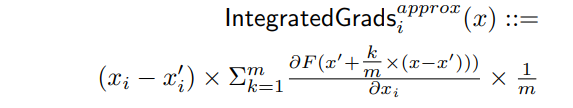

https://arxiv.org/pdf/1703.01365.pdf


*Why is Integrated Gradients superior to other interpretability techniques?*

-> it satisfies the two axioms **(Sensitivity and Implementation Invariance)**  that every attribution method must satisfy, but most known methods don't

-> it requires no modification to the original network

-> extraordinarily simple to implement

-> can be used to debug networks, extract rules from a network and enable the users of the network to engage beter with the model


For an easy-to-follow introduction to this topic, please read https://towardsdatascience.com/understanding-deep-learning-models-with-integrated-gradients-24ddce643dbf

In [2]:
import torch 
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import optim 
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


While training a model, we typically want to pass samples in “minibatches” (batch_size = 100), reshuffle the data at every epoch to reduce model overfitting (shuffle = True), and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

At the heart of PyTorch data loading utility is the **torch.utils.data.DataLoader** class. It represents **a Python iterable over a dataset**

The snippet below has visualisation purposes (to get a good grasp of how our data actually looks like)



Feature batch shape: torch.Size([100, 1, 28, 28])
Labels batch shape: torch.Size([100])


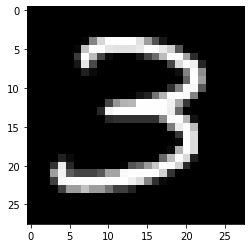

Label: 3
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,

In [ ]:
Data_train = torch.utils.data.DataLoader(mnist_trainset, 
                                          batch_size=100, 
                                          shuffle=True,
                                          num_workers=1)
# We have loaded our MNIST dataset into the Dataloader object and can iterate through the dataset as needed
print(Data_train)

train_features, train_labels = next(iter(Data_train))
#iter() calls the __iter__() method on the Data_train which returns an iterator
#next() then calls the __next__() method on that iterator to get the first iteration. Running next() again will get the second item of the iterator, etc
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
img = train_features[0].squeeze()
#torch.squeeze(input, dim=None, *, out=None) -> Returns a tensor with all the dimensions of input of size 1 removed.
# For example, if input is of shape:(A×1×B×C×1×D) then the out tensor will be of shape: (A×B×C×D).
label = train_labels[0]
plt.imshow(img, cmap = 'gray')
plt.show()
print(f'Label: {label}')
print(train_features)
print(train_labels)

Now, we'll create our  convolutional neural network architecture

**Out=In∗W+Bias**

In [ ]:
class CnnModel(nn.Module):
    def __init__(self):
        super(CnnModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, (5, 5), bias=True)
        self.flatt = nn.Flatten()
        self.dense1 = nn.Linear(576, 10)
        

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.flatt(x)
        x1 = self.dense1(x)
        return(F.softmax(x1))
        


In [ ]:
# We now instantiate an object (net) of the CnnModel class, net being our architecture 
net = CnnModel()

**Don't get confused!!**

Our dataset is divided in smaller compartments called *batches*.

The number of *epochs* is the number of times the whole dataset is passed forward and backward through the neural network at once. Since this would require big computational costs, we need to divide the data in batches of smaller sizes and feed our model with them one by one.


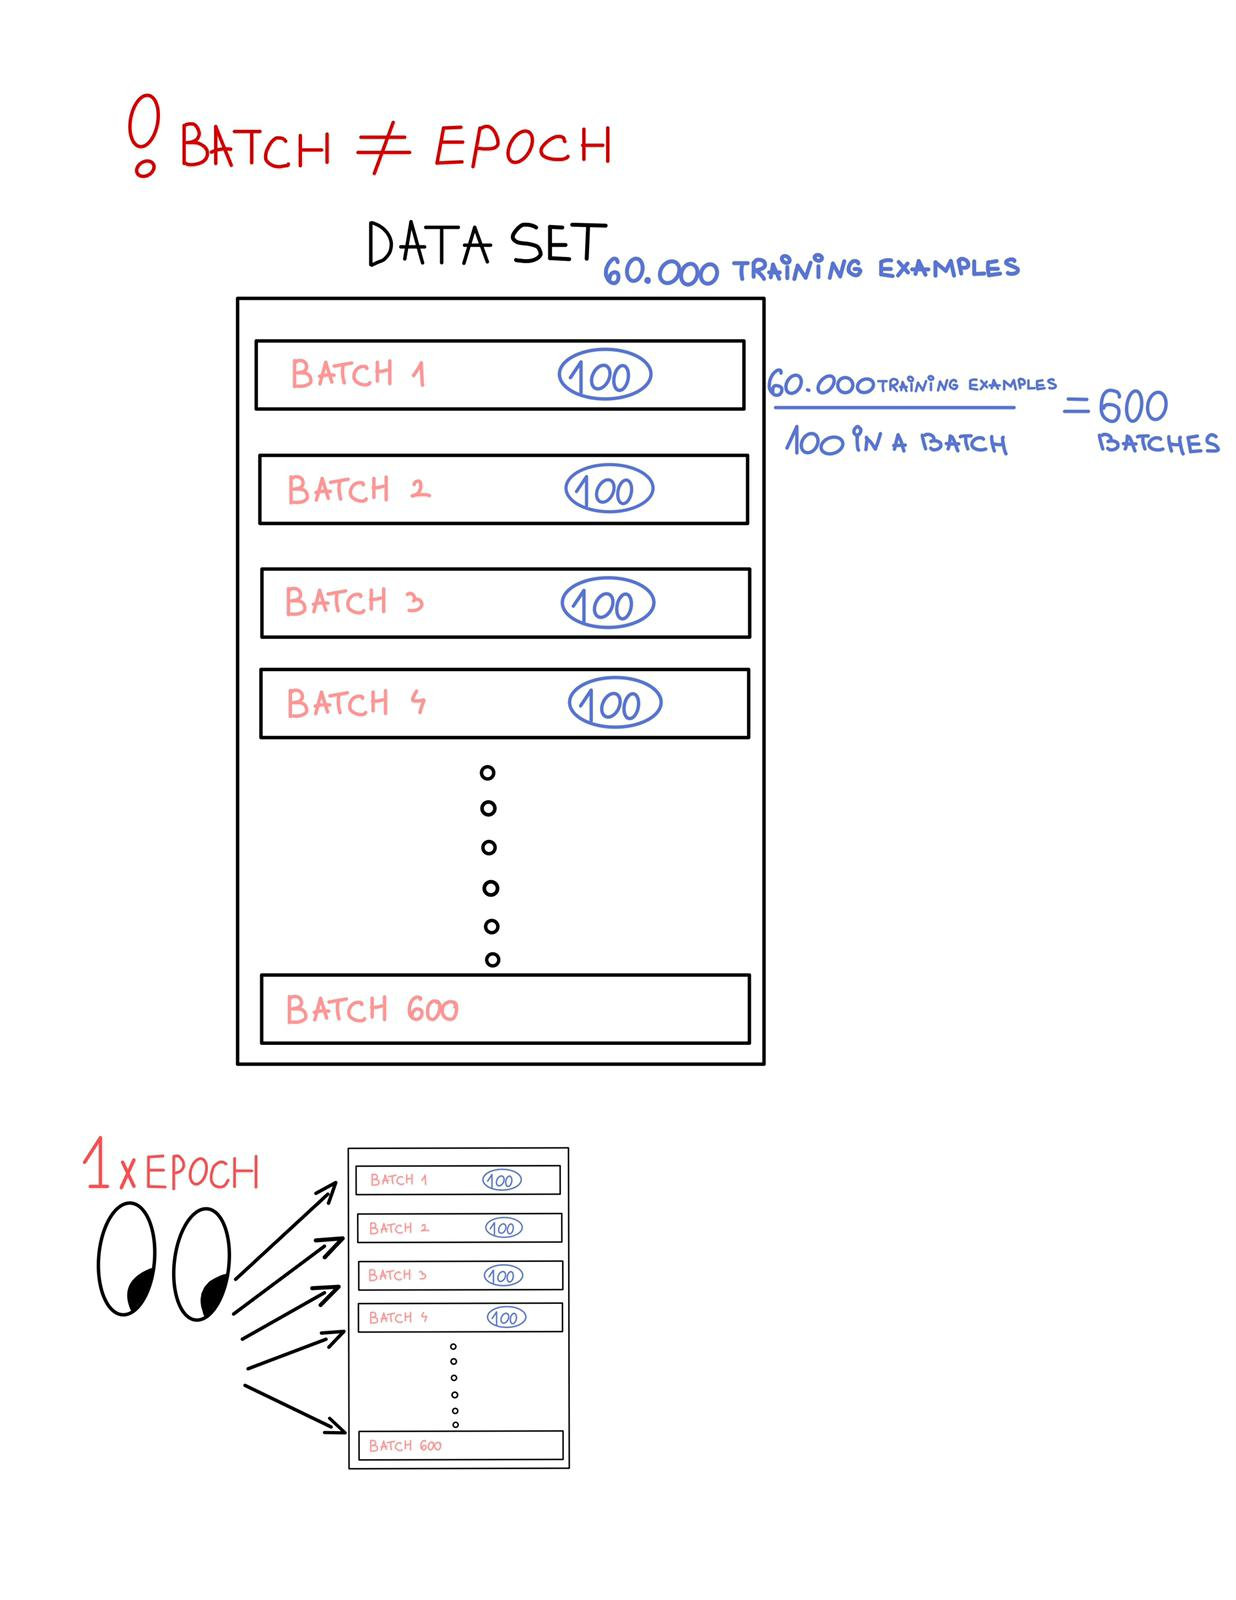

We'll use Cross-Entropy as our loss function. Cross-entropy builds upon the idea of entropy from information theory and calculates the number of bits required to represent or transmit an average event from one distribution compared to another distribution.

Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.


 For further details see 
1.   https://machinelearningmastery.com/cross-entropy-for-machine-learning/

2.   https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/



In [ ]:
optimizer = optim.Adam(net.parameters(), lr = 0.01) 
loss_func = nn.CrossEntropyLoss()  
num_epochs = 10
total_step = len(Data_train) 
for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(Data_train):
        b_x = Variable(images)   # images
        b_y = Variable(labels)   # labels
        output = net(b_x)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()  
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch [1/10], Step [100/600], Loss: 1.5656
Epoch [1/10], Step [200/600], Loss: 1.5331
Epoch [1/10], Step [300/600], Loss: 1.5583
Epoch [1/10], Step [400/600], Loss: 1.5758
Epoch [1/10], Step [500/600], Loss: 1.5238
Epoch [1/10], Step [600/600], Loss: 1.5676
Epoch [2/10], Step [100/600], Loss: 1.5509
Epoch [2/10], Step [200/600], Loss: 1.5337
Epoch [2/10], Step [300/600], Loss: 1.5804
Epoch [2/10], Step [400/600], Loss: 1.5514
Epoch [2/10], Step [500/600], Loss: 1.5579
Epoch [2/10], Step [600/600], Loss: 1.5123
Epoch [3/10], Step [100/600], Loss: 1.5360
Epoch [3/10], Step [200/600], Loss: 1.5246
Epoch [3/10], Step [300/600], Loss: 1.5379
Epoch [3/10], Step [400/600], Loss: 1.5180
Epoch [3/10], Step [500/600], Loss: 1.5309
Epoch [3/10], Step [600/600], Loss: 1.5590
Epoch [4/10], Step [100/600], Loss: 1.5604
Epoch [4/10], Step [200/600], Loss: 1.5419
Epoch [4/10], Step [300/600], Loss: 1.5235
Epoch [4/10], Step [400/600], Loss: 1.5244
Epoch [4/10], Step [500/600], Loss: 1.5259
Epoch [4/10

In [ ]:
# Every batch contains 100 images, as we set at the beggining, by giving the value 100 to the constructor argument 'mini_batch' .
for i, (image, labels) in enumerate(Data_train):
  print(f"Batch's number {i} ---> Images from the batch: {image} ---> Labels:  {labels}")
  
  

In [ ]:
# The iter() function (which in turn calls the __iter__() method) returns an iterator from them. Iterator in Python is simply an object that can be iterated upon
# We use the next() function to manually iterate through all the items of an iterator.
# When we reach the end and there is no more data to be returned, it will raise the StopIteration
# a Python iterator object must implement two special methods, __iter__() and __next__(), collectively called the iterator protocol.
it = iter(Data_train)
first = next(it) # this will output a list with 2 elements, corresponding to the first batch
second = next(it) # # this will output a list with 2 elements, corresponding to the second batch
print(type(first[0]))
print(type(first[1]))
print(type(first)) # first is a list containing 2 tensors
print(f'This is the tensorial representation of the images in the first batch: {first[0]}')
print(len(first[0]))
print(first[0].size())
print(f' Corresponding labels: {first[1]}')
print(len(first[1]))
print(first[1].size())


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'list'>
This is the tensorial representation of the images in the first batch: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.]

Label of this image: 0
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        

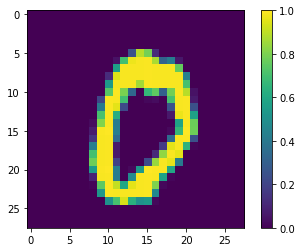

In [ ]:
print(f'Label of this image: {first[1][0].item()}')
#first[0][0] is the first image from the first batch
first[0][0].shape
first_ndarray = first[0][0].squeeze().numpy()
# numpy() function is the converter form torch.Tensor to numpy array. This implicitly means that the converted tensor will be now processed on the CPU
#as ndarrays can't run on GPU
print(first_ndarray)
plt.imshow(first_ndarray)
plt.colorbar()




Now, we'll prepare the right environment for implementing the Integrated Gradients method, using **Captum**, an open source, extensible library for model interpretability built on PyTorch. 

https://captum.ai/docs/introduction.html

In [ ]:
!pip install captum
from captum.attr import IntegratedGradients

     |████████████████████████████████| 1.4 MB 15.1 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


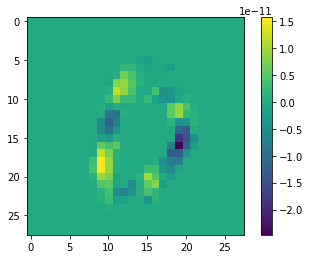

In [ ]:
input1 = first[0][0].reshape(1, 1, 28, 28)
input1.require_grad = True

baseline = torch.zeros(tuple(input1.size()))

ig = IntegratedGradients(net)
attributions = ig.attribute(input1, target = 8)

new_attributions = attributions.reshape(tuple(input1.squeeze().size()))

plt.imshow(new_attributions)
plt.colorbar()


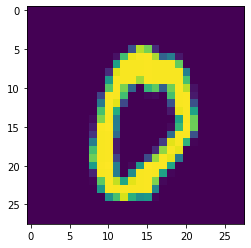

In [ ]:
input1.size()
# The size of input 1 is still torch.Size([1, 1, 28, 28]), so we are going to reshape it and plot input1


plt.imshow(input1.reshape(28, 28))